In [1]:
from dateutil.parser import parse
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
# Genuine Account CSV files
path_genuineAccounts_USERS = r"E:\edge下载\cresci-2017.csv\data\genuine_accounts.csv\genuine_accounts.csv\genuine_users.csv"
path_genuineAccounts_TWEETS = r"E:\edge下载\cresci-2017.csv\data\genuine_accounts.csv\genuine_accounts.csv\genuine_tweets.csv"

# Spam Bot Account CSV files
path_spamBots_USERS = r"E:\edge下载\cresci-2017.csv\data\social_spambots_1.csv\social_spambots_1.csv\social_users.csv"
path_spamBots_TWEETS = r"E:\edge下载\cresci-2017.csv\data\social_spambots_1.csv\social_spambots_1.csv\social_tweets.csv"

df_genuine_users = pd.read_csv(path_genuineAccounts_USERS, encoding='utf-8')
df_genuine_tweets = pd.read_csv(path_genuineAccounts_TWEETS, encoding='utf-8')
df_spambots_users = pd.read_csv(path_spamBots_USERS, encoding='utf-8')
df_spambots_tweets = pd.read_csv(path_spamBots_TWEETS, encoding='utf-8')

C:\Users\HP\AppData\Local\Temp\ipykernel_35188\2006017528.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_genuine_tweets = pd.read_csv(path_genuineAccounts_TWEETS, encoding='utf-8')
C:\Users\HP\AppData\Local\Temp\ipykernel_35188\2006017528.py:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_spambots_tweets = pd.read_csv(path_spamBots_TWEETS, encoding='utf-8')


In [3]:
df_genuine_users.columns

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'url', 'lang',
       'time_zone', 'location', 'default_profile', 'default_profile_image',
       'geo_enabled', 'profile_image_url', 'profile_banner_url',
       'profile_use_background_image', 'profile_background_image_url_https',
       'profile_text_color', 'profile_image_url_https',
       'profile_sidebar_border_color', 'profile_background_tile',
       'profile_sidebar_fill_color', 'profile_background_image_url',
       'profile_background_color', 'profile_link_color', 'utc_offset',
       'is_translator', 'follow_request_sent', 'protected', 'verified',
       'notifications', 'description', 'contributors_enabled', 'following',
       'created_at', 'timestamp', 'crawled_at', 'updated', 'test_set_1',
       'test_set_2'],
      dtype='object')

In [4]:
# 从 df_genuine_users 这个数据框中删除名为 test_set_1 和 test_set_2 的两列数据
# df_genuine_users.drop(columns=['test_set_1', 'test_set_2'], inplace=True)

In [5]:
# Dataset Preview
print(df_genuine_users.head())
print(df_genuine_tweets.head())

           id               name      screen_name  statuses_count  \
0  1502026416    TASUKU HAYAKAWA         0918Bask            2177   
1  2492782375              ro_or         1120Roll            2660   
2   293212315           bearclaw        14KBBrown            1254   
3   191839658  pocahontas farida      wadespeters          202968   
4  3020965143           Ms Kathy  191a5bd05da04dc              82   

   followers_count  friends_count  favourites_count  listed_count  \
0              208            332               265             1   
1              330            485              3972             5   
2              166            177              1185             0   
3             2248            981             60304           101   
4               21             79                 5             0   

                      url lang  ... notifications  \
0                     NaN   ja  ...           NaN   
1                     NaN   ja  ...           NaN   
2          

In [6]:
# 遍历 df_spambots_tweets 数据框的每一列，并打印出 df_genuine_tweets 数据框中第一行（索引为 0）对应列的值。
for column in df_spambots_tweets.columns:
  print(column + ": " + str(df_genuine_tweets.loc[0, column]))
# print(df_spambots_tweets.head(1))

id: 593932392663912449
text: RT @morningJewshow: Speaking about Jews and comedy tonight at Temple Emanu-El in San Francisco. In other words, my High Holidays.
source: <a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>
user_id: 678033.0
truncated: nan
in_reply_to_status_id: 0.0
in_reply_to_user_id: 0.0
in_reply_to_screen_name: nan
retweeted_status_id: 5.939321685245338e+17
geo: nan
place: nan
contributors: nan
retweet_count: 1.0
reply_count: 0.0
favorite_count: 0.0
favorited: nan
retweeted: nan
possibly_sensitive: nan
num_hashtags: 0.0
num_urls: 0.0
num_mentions: 1.0
created_at: Fri May 01 00:18:11 +0000 2015
timestamp: 2015-05-01 02:18:11
crawled_at: 2015-05-01 12:57:19
updated: 2015-05-01 12:57:19


In [9]:
# 将两个不同类型账户（真实账户和垃圾邮件机器人账户）对应的用户数据和推文数据分别进行合并操作
x_df = pd.concat([df_genuine_users, df_spambots_users])
tweets_df = pd.concat([df_genuine_tweets, df_spambots_tweets])

In [10]:
# 将输入的时间戳相关的字符串 ts 转换为一个数值形式的时间戳
def change_ts(ts):
  cts = 0
  try:
    cts = parse(ts).timestamp()
  except:
    cts = int(ts[:-1]) / 1000
  return cts

def get_intertime(df):
  tweet_timestamps = []
  
  for index, row in df.iterrows():
    tweet_timestamps.append(change_ts(str(row["created_at"])))

  # df["created_at"].values.tolist().map(change_ts)
  
  tweet_timestamps.sort()
  tts_diff = np.diff(np.array(tweet_timestamps))
  return sum(tts_diff) / (len(tts_diff) if len(tts_diff) != 0 else 1)

In [11]:
import numpy as np
# 基于已有的用户数据框 x_df 和推文数据框 tweets_df，为每个用户计算一系列特征值，并将这些特征值组成列表后添加到 x_vector 列表中，最终形成一个包含所有用户特征向量的列表，可用于后续的数据分析、建模等操作
x_vector = []

for index, row in x_df.iterrows():
  # current user's id
  usr = row['id']
  usr_tweets_df = tweets_df.loc[tweets_df["user_id"] == usr]
  tweet_count = len(usr_tweets_df) if len(usr_tweets_df) != 0 else 1

  # calculate features
  retweets = len(usr_tweets_df[usr_tweets_df.retweeted_status_id != 0]) / tweet_count
  replies = len(usr_tweets_df[usr_tweets_df.in_reply_to_status_id != 0]) / tweet_count
  favoriteC = row["favourites_count"] / tweet_count
  hashtag = sum(usr_tweets_df["num_hashtags"].values.tolist()) / tweet_count
  url = sum(usr_tweets_df["num_urls"].values.tolist()) / tweet_count
  mentions = sum(usr_tweets_df["num_mentions"].values.tolist()) / tweet_count
  intertime = get_intertime(usr_tweets_df)
  ffratio = row["friends_count"]/(row["followers_count"] if row["followers_count"] != 0 else 1)
  favorites = row["favourites_count"]
  listed = row["listed_count"]
  uniqueHashtags = -1
  uniqueMentions = -1
  uniqueURL = -1

  usr_features = [retweets, replies, favoriteC, hashtag, url, mentions, intertime, ffratio, favorites, listed]
  # usr_features = [retweets, replies, favoriteC, hashtag, url, mentions, intertime, ffratio]
  x_vector.append(usr_features)


In [12]:
# 对 x_vector 中的数据进行归一化处理。归一化操作通常是为了将数据的特征值映射到特定的区间，以便在后续的数据分析、机器学习或深度学习等任务中，不同特征之间具有可比性，并且能够提升模型的训练效果和性能等
x = preprocessing.normalize(x_vector)

In [13]:
# 将经过归一化处理后的数据（存储在变量 x 中）转换为一个 Pandas 数据框 df，然后设置显示选项以展示数据框的所有列，并打印出数据框的前几行数据进行查看，最后重置之前设置的显示选项
df = pd.DataFrame(x, columns=['retweets', 'replies', 'favoriteC', 'hashtag', 'url', 'mentions', 'intertime', 'ffratio', 'favorites', 'listed'])
# df = pd.DataFrame(x, columns=['retweets', 'replies', 'favoriteC', 'hashtag', 'url', 'mentions', 'intertime', 'ffratio'])
pd.set_option('display.max_columns', None)
print(df.head())
pd.reset_option('max_columns')

   retweets   replies  favoriteC   hashtag       url  mentions  intertime  \
0  0.000000  0.000000   0.707098  0.000000  0.000000  0.000000    0.00000   
1  0.000000  0.000000   0.707106  0.000000  0.000000  0.000000    0.00000   
2  0.000000  0.000000   0.707107  0.000000  0.000000  0.000000    0.00000   
3  0.000006  0.000005   0.000311  0.000002  0.000002  0.000014    0.00887   
4  0.000000  0.000000   0.624259  0.000000  0.000000  0.000000    0.00000   

    ffratio  favorites    listed  
0  0.004259   0.707098  0.002668  
1  0.000262   0.707106  0.000890  
2  0.000636   0.707107  0.000000  
3  0.000007   0.999959  0.001675  
4  0.469681   0.624259  0.000000  


In [15]:
# 创建一个用于标记数据类别的标签列表 y，其中标签值根据数据来源进行设定：来自 df_genuine_users 的数据对应的标签为 0，来自 df_spamBots_users 的数据对应的标签为 1
y = np.zeros(len(df_genuine_users), dtype=int).tolist() + np.ones(len(df_spambots_users), dtype=int).tolist()

In [16]:
# 对特征数据 x 和对应的标签数据 y 进行随机打乱操作
x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [17]:
results = []

# 向量机

In [18]:
# 实现了使用支持向量机（SVC）算法中的线性核函数构建分类器，对经过预处理和划分好的训练数据进行训练，然后用训练好的模型对测试数据进行预测，并通过多种评估指标来评估模型的性能，包括分类报告以及混淆矩阵相关指标（真正例、真反例、假正例、假反例）的输出。
SVC_linear_classifier = SVC(kernel='linear', probability=True)
SVC_linear_classifier.fit(x_train, y_train)

y_pred = SVC_linear_classifier.predict(x_test)

# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, target_names=['Human', 'Bot']))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

              precision    recall  f1-score   support

       Human       0.99      0.86      0.92       886
         Bot       0.64      0.98      0.77       231

    accuracy                           0.88      1117
   macro avg       0.82      0.92      0.85      1117
weighted avg       0.92      0.88      0.89      1117

True Negatives:  759
False Positives:  127
False Negatives:  5
True Positives:  226


In [19]:
# 基于前面已经训练好的支持向量机线性分类器（SVC_linear_classifier），计算其接收者操作特征曲线（ROC 曲线）相关的数据，并求出曲线下面积（AUC）值，最后将相关结果添加到一个列表（results）中，用于后续可能的结果展示、分析或比较等操作。
fpr, tpr, _ = roc_curve(y_test,  SVC_linear_classifier.predict_proba(x_test)[:,1])
auc = roc_auc_score(y_test, SVC_linear_classifier.predict_proba(x_test)[:,1])
results.append([fpr,tpr,"SVM Linear Kernel, AUC={:.3f}".format(auc)])

In [20]:
# 使用支持向量机（SVC）算法中的多项式核函数（kernel='poly'）构建分类器，对给定的训练数据进行训练，然后利用训练好的分类器对测试数据进行预测，并通过分类报告、混淆矩阵相关指标等来评估该多项式核函数支持向量机分类器的性能
SVC_poly_classifier = SVC(kernel='poly', probability=True)
SVC_poly_classifier.fit(x_train, y_train)

y_pred = SVC_poly_classifier.predict(x_test)

# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, target_names=['Human', 'Bot']))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

              precision    recall  f1-score   support

       Human       0.99      0.88      0.93       886
         Bot       0.68      0.98      0.81       231

    accuracy                           0.90      1117
   macro avg       0.84      0.93      0.87      1117
weighted avg       0.93      0.90      0.91      1117

True Negatives:  782
False Positives:  104
False Negatives:  5
True Positives:  226


In [21]:
# 基于已经训练好的采用多项式核函数的支持向量机分类器（SVC_poly_classifier），计算其接收者操作特征曲线（ROC 曲线）相关的数据，并求出曲线下面积（AUC）值，最后将这些结果添加到 results 列表中，以便后续对不同模型（如果有多个模型进行类似评估）的性能进行比较、展示或进一步分析等操作
fpr, tpr, _ = roc_curve(y_test,  SVC_poly_classifier.predict_proba(x_test)[:,1])
auc = roc_auc_score(y_test, SVC_poly_classifier.predict_proba(x_test)[:,1])
results.append([fpr,tpr,"SVM Polynominal Kernel, AUC={:.3f}".format(auc)])

# Random Forest Classifier

In [22]:
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)

RandomForestClassifier()

In [23]:
y_pred = rfc_model.predict(x_test)

In [24]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       0.99      1.00      0.99       886
         Bot       0.98      0.96      0.97       231

    accuracy                           0.99      1117
   macro avg       0.99      0.98      0.98      1117
weighted avg       0.99      0.99      0.99      1117



In [25]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[882   4]
 [ 10 221]]
True Negatives: 882, False Positives: 4, False Negatives: 10, True Positives: 221


In [26]:
fpr, tpr, _ = roc_curve(y_test,  rfc_model.predict_proba(x_test)[:,1])
auc = roc_auc_score(y_test, rfc_model.predict_proba(x_test)[:,1])
results.append([fpr,tpr,"RFC, AUC={:.3f}".format(auc)])

# Logistic Regression

In [27]:
logreg_model = LogisticRegression()
logreg_model.fit(x_train, y_train)

LogisticRegression()

In [28]:
y_pred = logreg_model.predict(x_test)

In [29]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       0.99      0.86      0.92       886
         Bot       0.65      0.98      0.78       231

    accuracy                           0.89      1117
   macro avg       0.82      0.92      0.85      1117
weighted avg       0.92      0.89      0.89      1117



In [30]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[765 121]
 [  5 226]]
True Negatives: 765, False Positives: 121, False Negatives: 5, True Positives: 226


In [31]:
fpr, tpr, _ = roc_curve(y_test,  logreg_model.predict_proba(x_test)[:,1])
auc = roc_auc_score(y_test, logreg_model.predict_proba(x_test)[:,1])
results.append([fpr,tpr,"Log Regression, AUC={:.3f}".format(auc)])

# Naive Bayes #Gaussian NB


In [32]:
n_bayes = GaussianNB()
n_bayes.fit(x_train, y_train) 

GaussianNB()

In [33]:
expected = y_test
predicted = n_bayes.predict(x_test)

In [34]:
print(classification_report(expected, predicted, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       0.99      0.83      0.91       886
         Bot       0.60      0.98      0.75       231

    accuracy                           0.86      1117
   macro avg       0.80      0.91      0.83      1117
weighted avg       0.91      0.86      0.87      1117



In [35]:
print(confusion_matrix(expected, predicted))

[[738 148]
 [  5 226]]


In [36]:
tn, fp, fn, tp = confusion_matrix(expected, predicted).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

True Negatives: 738, False Positives: 148, False Negatives: 5, True Positives: 226


In [37]:
fpr, tpr, _ = roc_curve(y_test,  n_bayes.predict_proba(x_test)[:,1])
auc = roc_auc_score(y_test, n_bayes.predict_proba(x_test)[:,1])
results.append([fpr,tpr,"Gaussian NB, AUC={:.3f}".format(auc)])

# Complement NB

In [38]:
cn_bayes = ComplementNB()
cn_bayes.fit(x_train, y_train)

ComplementNB()

In [39]:
y_pred = cn_bayes.predict(x_test)

In [40]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       1.00      0.81      0.89       886
         Bot       0.58      0.99      0.73       231

    accuracy                           0.85      1117
   macro avg       0.79      0.90      0.81      1117
weighted avg       0.91      0.85      0.86      1117



In [41]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[718 168]
 [  3 228]]
True Negatives: 718, False Positives: 168, False Negatives: 3, True Positives: 228


In [42]:
fpr, tpr, _ = roc_curve(y_test,  cn_bayes.predict_proba(x_test)[:,1])
auc = roc_auc_score(y_test, cn_bayes.predict_proba(x_test)[:,1])
results.append([fpr,tpr,"Complement NB, AUC={:.3f}".format(auc)])

# Neural Network

In [43]:
# parameters
batch_size = 32
epochs = 20

In [44]:
model = tf.keras.Sequential([
  layers.Dense(10),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(np.array(x_train),
          np.array(y_train),
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py:750: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8144 - loss: 0.4267
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8953 - loss: 0.2223
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9085 - loss: 0.2138  
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9176 - loss: 0.2014  
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9303 - loss: 0.1854  
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9207 - loss: 0.1944  
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9280 - loss: 0.1845
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9285 - loss: 0.1827
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9345 - loss: 0.1833  
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9381 - loss: 0.1577
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9394 - loss: 0.1602  
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

In [45]:
loss, accuracy = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Accuracy: ", accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.1539 
Accuracy:  0.9364368915557861


In [46]:
# # 但是不知道为什么会导致模型准确率很低，再尝试下面换成这一行代码，准确率正常了

# # （而且后面可视化图形也画不出来，猜测原因应该是数据维度的原因）
# # 使用 predict 方法获取预测概率
# y_pred_probs = model.predict(x_test, verbose=0)

# # 将预测概率转换为类别标签
# y_pred = np.argmax(y_pred_probs, axis=1)

In [48]:
y_pred = (model.predict(x_test)>0.5).astype('int32')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [49]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

              precision    recall  f1-score   support

       Human       0.99      0.93      0.96       886
         Bot       0.78      0.97      0.86       231

    accuracy                           0.94      1117
   macro avg       0.89      0.95      0.91      1117
weighted avg       0.95      0.94      0.94      1117



In [50]:
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

[[823  63]
 [  8 223]]
True Negatives: 823, False Positives: 63, False Negatives: 8, True Positives: 223


In [51]:
fpr, tpr, _ = roc_curve(y_test,  model.predict(x_test).ravel())
auc = roc_auc_score(y_test, model.predict(x_test).ravel())
results.append([fpr,tpr,"Neural Network, AUC={:.3f}".format(auc)])

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


# ROC Curves

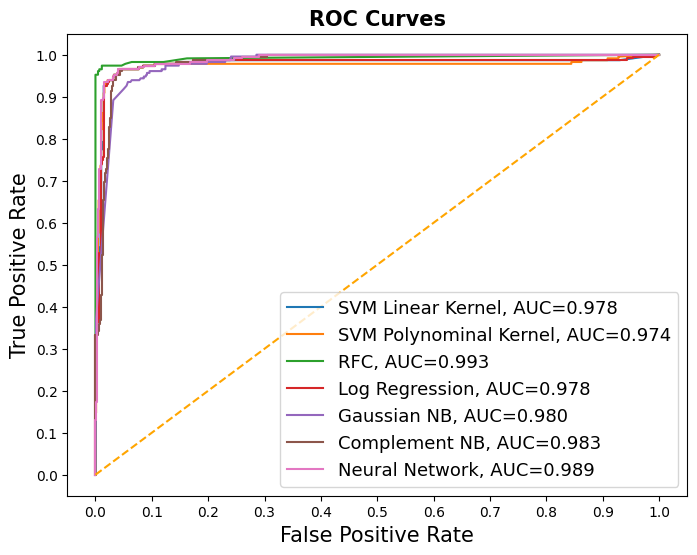

In [52]:
fig = plt.figure(figsize=(8,6))

for result in results:
    plt.plot(result[0], result[1], label=result[2])

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curves', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [53]:
models = {}
models['SVC_linear_classifier'] = SVC_linear_classifier
models['SVC_poly_classifier'] = SVC_poly_classifier
models['rfc_model'] = rfc_model
models['logreg_model'] = logreg_model
models['n_bayes'] = n_bayes
models['cn_bayes'] = cn_bayes
models['neural_network'] = model

In [54]:
import joblib

# 假设 models 是一个字典，包含所有训练好的模型
for model_name, model in models.items():
    joblib.dump(model, f'D:/{model_name}_model.pkl')
# 保存神经网络模型
model.save('D:/neural_network_model.keras')

In [60]:
from tensorflow.keras.models import load_model

# 加载 SVC 模型
svc_linear = joblib.load('D:/SVC_linear_classifier_model.pkl')
svc_poly = joblib.load('D:/SVC_poly_classifier_model.pkl')

# 加载随机森林模型
rfc_model = joblib.load('D:/rfc_model_model.pkl')

# 加载逻辑回归模型
logreg_model = joblib.load('D:/logreg_model_model.pkl')

# 加载高斯朴素贝叶斯模型
n_bayes = joblib.load('D:/n_bayes_model.pkl')

# 加载互补朴素贝叶斯模型
cn_bayes = joblib.load('D:/cn_bayes_model.pkl')

# 加载神经网络模型
model = load_model('D:/neural_network_model.keras', compile=False)

# 重新编译模型
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])